# Step 5 – Analytics Marts (Gold)

Goal:
Create reusable BI-ready tables (“marts”) from the star schema.

Marts included:
- Market share by month (top manufacturers)
- YoY growth by manufacturer
- Seasonality index (month-of-year pattern)
- State × manufacturer rankings
- Model Pareto (80/20) analysis

Note:
The fact table excludes 289 rows with missing trade_name (strict dimensional integrity).


2) Connect to DuckDB

In [29]:
# Crisp plots in Jupyter
%config InlineBackend.figure_format = 'retina'

import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter



In [30]:
plt.style.use("seaborn-v0_8-whitegrid")  # nice defaults

mpl.rcParams.update({
    "figure.figsize": (12, 5),
    "figure.dpi": 130,          # sharper in notebook
    "savefig.dpi": 300,         # crisp exports
    "font.size": 11,
    "axes.titlesize": 14,
    "axes.labelsize": 11,
    "xtick.labelsize": 9,
    "ytick.labelsize": 10,
    "axes.spines.top": False,
    "axes.spines.right": False,
    "legend.frameon": False,
})


In [31]:
def fmt_commas(x, pos):
    return f"{int(x):,}"

comma_formatter = FuncFormatter(fmt_commas)

def save_fig(name: str):
    plt.tight_layout()
    plt.savefig(f"../outputs/{name}.png", dpi=300, bbox_inches="tight")
    plt.savefig(f"../outputs/{name}.svg", bbox_inches="tight")  # best for dashboards


In [32]:
plt.style.use("tableau-colorblind10")


In [33]:
# Crisp plots in Jupyter
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.ticker import FuncFormatter

plt.style.use("seaborn-v0_8-whitegrid")

mpl.rcParams.update({
    "figure.figsize": (12, 6),
    "figure.dpi": 140,          # sharper inline
    "savefig.dpi": 320,         # very crisp exports
    "font.size": 11,
    "axes.titlesize": 15,
    "axes.labelsize": 11,
    "xtick.labelsize": 9,
    "ytick.labelsize": 10,
    "axes.spines.top": False,
    "axes.spines.right": False,
    "legend.frameon": False,
})


In [34]:
from pathlib import Path

# Tableau-like palette
PALETTE = [
    "#4E79A7", "#F28E2B", "#E15759", "#76B7B2",
    "#59A14F", "#EDC948", "#B07AA1", "#FF9DA7",
    "#9C755F", "#BAB0AC"
]

HIGHLIGHT = "#4E79A7"
MUTED = "#D0D0D0"

def fmt_commas(x, pos):
    try:
        return f"{int(x):,}"
    except Exception:
        return str(x)

comma_formatter = FuncFormatter(fmt_commas)

OUT_DIR = Path("../outputs")
OUT_DIR.mkdir(parents=True, exist_ok=True)

def polish_axes(ax):
    ax.grid(True, alpha=0.22)
    ax.set_axisbelow(True)
    ax.spines["left"].set_alpha(0.3)
    ax.spines["bottom"].set_alpha(0.3)
    return ax

def save_fig(name: str):
    plt.tight_layout()
    plt.savefig(OUT_DIR / f"{name}.png", bbox_inches="tight")
    plt.savefig(OUT_DIR / f"{name}.svg", bbox_inches="tight")  # best for Tableau/PowerBI


In [35]:
import duckdb
from pathlib import Path

DB_PATH = Path("../data/duckdb/motorcycle.db")
con = duckdb.connect(str(DB_PATH), read_only=False)

con.execute("SELECT COUNT(*) AS fact_rows FROM fct_registrations").fetchdf()


,fact_rows
0,128430


3) Create a “denormalized” view for easy mart building

    This makes everything faster to query.

In [36]:
con.execute("DROP VIEW IF EXISTS vw_registrations")

con.execute("""
CREATE VIEW vw_registrations AS
SELECT
  dd.date,
  dd.year,
  dd.month,
  dd.year_month,
  ds.state,
  dm.manufacturer,
  dmo.trade_name,
  dmo.type_key,
  f.registrations_count,
  f.Object_Id
FROM fct_registrations f
JOIN dim_date_keyed dd ON f.date_id = dd.date_id
JOIN dim_state_keyed ds ON f.state_id = ds.state_id
JOIN dim_manufacturer_keyed dm ON f.manufacturer_id = dm.manufacturer_id
JOIN dim_model_keyed dmo ON f.model_id = dmo.model_id
""")


In [37]:
con.execute("SELECT * FROM vw_registrations LIMIT 5").fetchdf()


,date,year,month,year_month,state,manufacturer,trade_name,type_key,registrations_count,Object_Id
0,2025-01-01,2025,1,2025-01,Nordrhein-Westfalen,PIAGGIO (I),"Vespa Primavera 125,Vespa",APM,284,117331
1,2025-01-01,2025,1,2025-01,Schleswig-Holstein,SUZUKI (J),"GSX-S1000S,GSX-S1000T,GSX",AFN,126,117332
2,2025-01-01,2025,1,2025-01,Mecklenburg-Vorpommern,SUZUKI (J),GSF 400 BANDIT,189,6,117333
3,2025-01-01,2025,1,2025-01,Hessen,PIAGGIO (I),"Vespa Primavera 125,Vespa",APM,138,117334
4,2025-01-01,2025,1,2025-01,Hamburg,SUZUKI (J),"GSX-S1000S,GSX-S1000T,GSX",AFN,35,117335


MART 1 — Market share by month (Top manufacturers)

    4) Create mart_market_share_monthly

In [38]:
con.execute("DROP TABLE IF EXISTS mart_market_share_monthly")

con.execute("""
CREATE TABLE mart_market_share_monthly AS
WITH monthly AS (
  SELECT
    year_month,
    manufacturer,
    SUM(registrations_count) AS registrations
  FROM vw_registrations
  GROUP BY 1, 2
),
totals AS (
  SELECT
    year_month,
    SUM(registrations) AS total_registrations
  FROM monthly
  GROUP BY 1
)
SELECT
  m.year_month,
  m.manufacturer,
  m.registrations,
  t.total_registrations,
  ROUND(100.0 * m.registrations / NULLIF(t.total_registrations, 0), 4) AS market_share_pct
FROM monthly m
JOIN totals t USING (year_month)
""")


In [39]:
con.execute("""
SELECT * FROM mart_market_share_monthly
ORDER BY year_month DESC, market_share_pct DESC
LIMIT 20
""").fetchdf()


,year_month,manufacturer,registrations,total_registrations,market_share_pct
0,2025-01,BMW,650864.0,5056626.0,12.8715
1,2025-01,PIAGGIO (I),482707.0,5056626.0,9.5460
2,2025-01,YAMAHA (J),474836.0,5056626.0,9.3904
3,2025-01,SUZUKI (J),439326.0,5056626.0,8.6881
4,2025-01,HONDA MOTOR (J),399437.0,5056626.0,7.8993
5,2025-01,KAWASAKI (J),381836.0,5056626.0,7.5512
6,2025-01,HARLEY-DAVIDSON(USA),302951.0,5056626.0,5.9912
7,2025-01,SONSTIGE HERSTELLER,252416.0,5056626.0,4.9918
8,2025-01,KTM (A),234350.0,5056626.0,4.6345
9,2025-01,HONDA (I),152359.0,5056626.0,3.0131


MART 2 — YoY growth by manufacturer

 5) Create mart_yoy_growth_manufacturer

In [40]:
con.execute("DROP TABLE IF EXISTS mart_yoy_growth_manufacturer")

con.execute("""
CREATE TABLE mart_yoy_growth_manufacturer AS
WITH yearly AS (
  SELECT
    year,
    manufacturer,
    SUM(registrations_count) AS registrations
  FROM vw_registrations
  GROUP BY 1, 2
),
lagged AS (
  SELECT
    *,
    LAG(registrations) OVER (PARTITION BY manufacturer ORDER BY year) AS prev_year_registrations
  FROM yearly
)
SELECT
  year,
  manufacturer,
  registrations,
  prev_year_registrations,
  CASE
    WHEN prev_year_registrations IS NULL OR prev_year_registrations = 0 THEN NULL
    ELSE ROUND(100.0 * (registrations - prev_year_registrations) / prev_year_registrations, 2)
  END AS yoy_growth_pct
FROM lagged
""")


In [41]:
con.execute("""
SELECT * FROM mart_yoy_growth_manufacturer
ORDER BY year DESC, yoy_growth_pct DESC
LIMIT 30
""").fetchdf()


,year,manufacturer,registrations,prev_year_registrations,yoy_growth_pct
0,2025,ZHEJIANG CFMOTO (RC),5520.0,3823.0,44.39
1,2025,BETAMOTOR (I),19920.0,15293.0,30.26
2,2025,ZHEJIANG QIANJIANG (RC),5030.0,3891.0,29.27
3,2025,FANTIC MOTOR (I),9195.0,7289.0,26.15
4,2025,XIAMEN XIASHING (RC),7370.0,6090.0,21.02
5,2025,HONDA (VN),8681.0,7208.0,20.44
6,2025,GUANGDONG TAYO (RC),4521.0,3857.0,17.22
7,2025,PIAGGIO (VN),25629.0,21909.0,16.98
8,2025,JINAN QINGQI KR (RC),5701.0,4976.0,14.57
9,2025,BENELLI (I),10904.0,9570.0,13.94


MART 3 — Seasonality index (month-of-year pattern)

6) Create mart_seasonality_index

This computes each month’s avg vs overall monthly avg (index 100 = average month).

In [42]:
con.execute("DROP TABLE IF EXISTS mart_seasonality_index")

con.execute("""
CREATE TABLE mart_seasonality_index AS
WITH monthly_total AS (
  SELECT
    year_month,
    month,
    SUM(registrations_count) AS registrations
  FROM vw_registrations
  GROUP BY 1, 2
),
overall AS (
  SELECT AVG(registrations) AS avg_monthly_registrations
  FROM monthly_total
),
month_avg AS (
  SELECT
    month,
    AVG(registrations) AS avg_registrations_in_month
  FROM monthly_total
  GROUP BY 1
)
SELECT
  m.month,
  m.avg_registrations_in_month,
  o.avg_monthly_registrations,
  ROUND(100.0 * m.avg_registrations_in_month / NULLIF(o.avg_monthly_registrations, 0), 2) AS seasonality_index
FROM month_avg m
CROSS JOIN overall o
ORDER BY month
""")


In [43]:
con.execute("SELECT * FROM mart_seasonality_index").fetchdf()


,month,avg_registrations_in_month,avg_monthly_registrations,seasonality_index
0,1,4.984653e+06,4.984653e+06,100.0


MART 4 — State × manufacturer ranking

7) Create mart_state_manufacturer_rank

In [44]:
con.execute("DROP TABLE IF EXISTS mart_state_manufacturer_rank")

con.execute("""
CREATE TABLE mart_state_manufacturer_rank AS
WITH totals AS (
  SELECT
    state,
    manufacturer,
    SUM(registrations_count) AS registrations
  FROM vw_registrations
  GROUP BY 1, 2
),
ranked AS (
  SELECT
    *,
    DENSE_RANK() OVER (PARTITION BY state ORDER BY registrations DESC) AS manufacturer_rank_in_state
  FROM totals
)
SELECT * FROM ranked
""")


In [45]:
con.execute("""
SELECT *
FROM mart_state_manufacturer_rank
WHERE manufacturer_rank_in_state <= 5
ORDER BY state, manufacturer_rank_in_state
""").fetchdf()


,state,manufacturer,registrations,manufacturer_rank_in_state
0,Baden-Württemberg,BMW,321134.0,1
1,Baden-Württemberg,PIAGGIO (I),268602.0,2
2,Baden-Württemberg,YAMAHA (J),213220.0,3
3,Baden-Württemberg,SUZUKI (J),192868.0,4
4,Baden-Württemberg,HONDA MOTOR (J),180372.0,5
...,...,...,...,...
80,Thüringen,MOTORRADW. ZSCHOP.-MZ,49805.0,1
81,Thüringen,SUZUKI (J),32741.0,2
82,Thüringen,YAMAHA (J),29131.0,3
83,Thüringen,KAWASAKI (J),29127.0,4


MART 5 — Model Pareto (80/20)

8) Create mart_model_pareto

In [46]:
con.execute("DROP TABLE IF EXISTS mart_model_pareto")

con.execute("""
CREATE TABLE mart_model_pareto AS
WITH model_totals AS (
  SELECT
    manufacturer,
    trade_name,
    type_key,
    SUM(registrations_count) AS registrations
  FROM vw_registrations
  GROUP BY 1, 2, 3
),
overall AS (
  SELECT SUM(registrations) AS total_registrations
  FROM model_totals
),
ranked AS (
  SELECT
    *,
    SUM(registrations) OVER (ORDER BY registrations DESC) AS cumulative_registrations
  FROM model_totals
)
SELECT
  r.*,
  o.total_registrations,
  ROUND(100.0 * r.registrations / NULLIF(o.total_registrations, 0), 6) AS share_pct,
  ROUND(100.0 * r.cumulative_registrations / NULLIF(o.total_registrations, 0), 2) AS cumulative_share_pct
FROM ranked r
CROSS JOIN overall o
ORDER BY registrations DESC
""")


In [47]:
con.execute("""
SELECT manufacturer, trade_name, type_key, registrations, share_pct, cumulative_share_pct
FROM mart_model_pareto
LIMIT 30
""").fetchdf()


,manufacturer,trade_name,type_key,registrations,share_pct,cumulative_share_pct
0,SONSTIGE HERSTELLER,,,757913.0,5.068310,5.07
1,YAMAHA (J),SONSTIGE/NICHT GETYPT,,563884.0,3.770801,8.84
2,HONDA MOTOR (J),SONSTIGE/NICHT GETYPT,,492949.0,3.296445,12.14
3,SUZUKI (J),SONSTIGE/NICHT GETYPT,,470616.0,3.147100,15.28
4,PIAGGIO (I),SONSTIGE/NICHT GETYPT,,366816.0,2.452969,17.74
5,BMW,SONSTIGE/NICHT GETYPT,,345199.0,2.308412,20.04
6,HARLEY-DAVIDSON(USA),SONSTIGE/NICHT GETYPT,,307825.0,2.058485,22.10
7,KAWASAKI (J),SONSTIGE/NICHT GETYPT,,306489.0,2.049551,24.15
8,MOTORRADW. ZSCHOP.-MZ,SONSTIGE/NICHT GETYPT,,249710.0,1.669859,25.82
9,KYMCO (RC),SONSTIGE/NICHT GETYPT,,140218.0,0.937665,26.76


9) Export marts to CSV (for Tableau/Power BI)

In [48]:
OUTPUT_CSV = Path("../outputs/csv")
OUTPUT_CSV.mkdir(parents=True, exist_ok=True)

exports = [
    "mart_market_share_monthly",
    "mart_yoy_growth_manufacturer",
    "mart_seasonality_index",
    "mart_state_manufacturer_rank",
    "mart_model_pareto",
]

for t in exports:
    df = con.execute(f"SELECT * FROM {t}").fetchdf()
    df.to_csv(OUTPUT_CSV / f"{t}.csv", index=False)

sorted([p.name for p in OUTPUT_CSV.glob("*.csv")])


['mart_market_share_monthly.csv',
 'mart_model_pareto.csv',
 'mart_seasonality_index.csv',
 'mart_state_manufacturer_rank.csv',
 'mart_yoy_growth_manufacturer.csv']

10) Quick charts

10.1 Total registrations by month

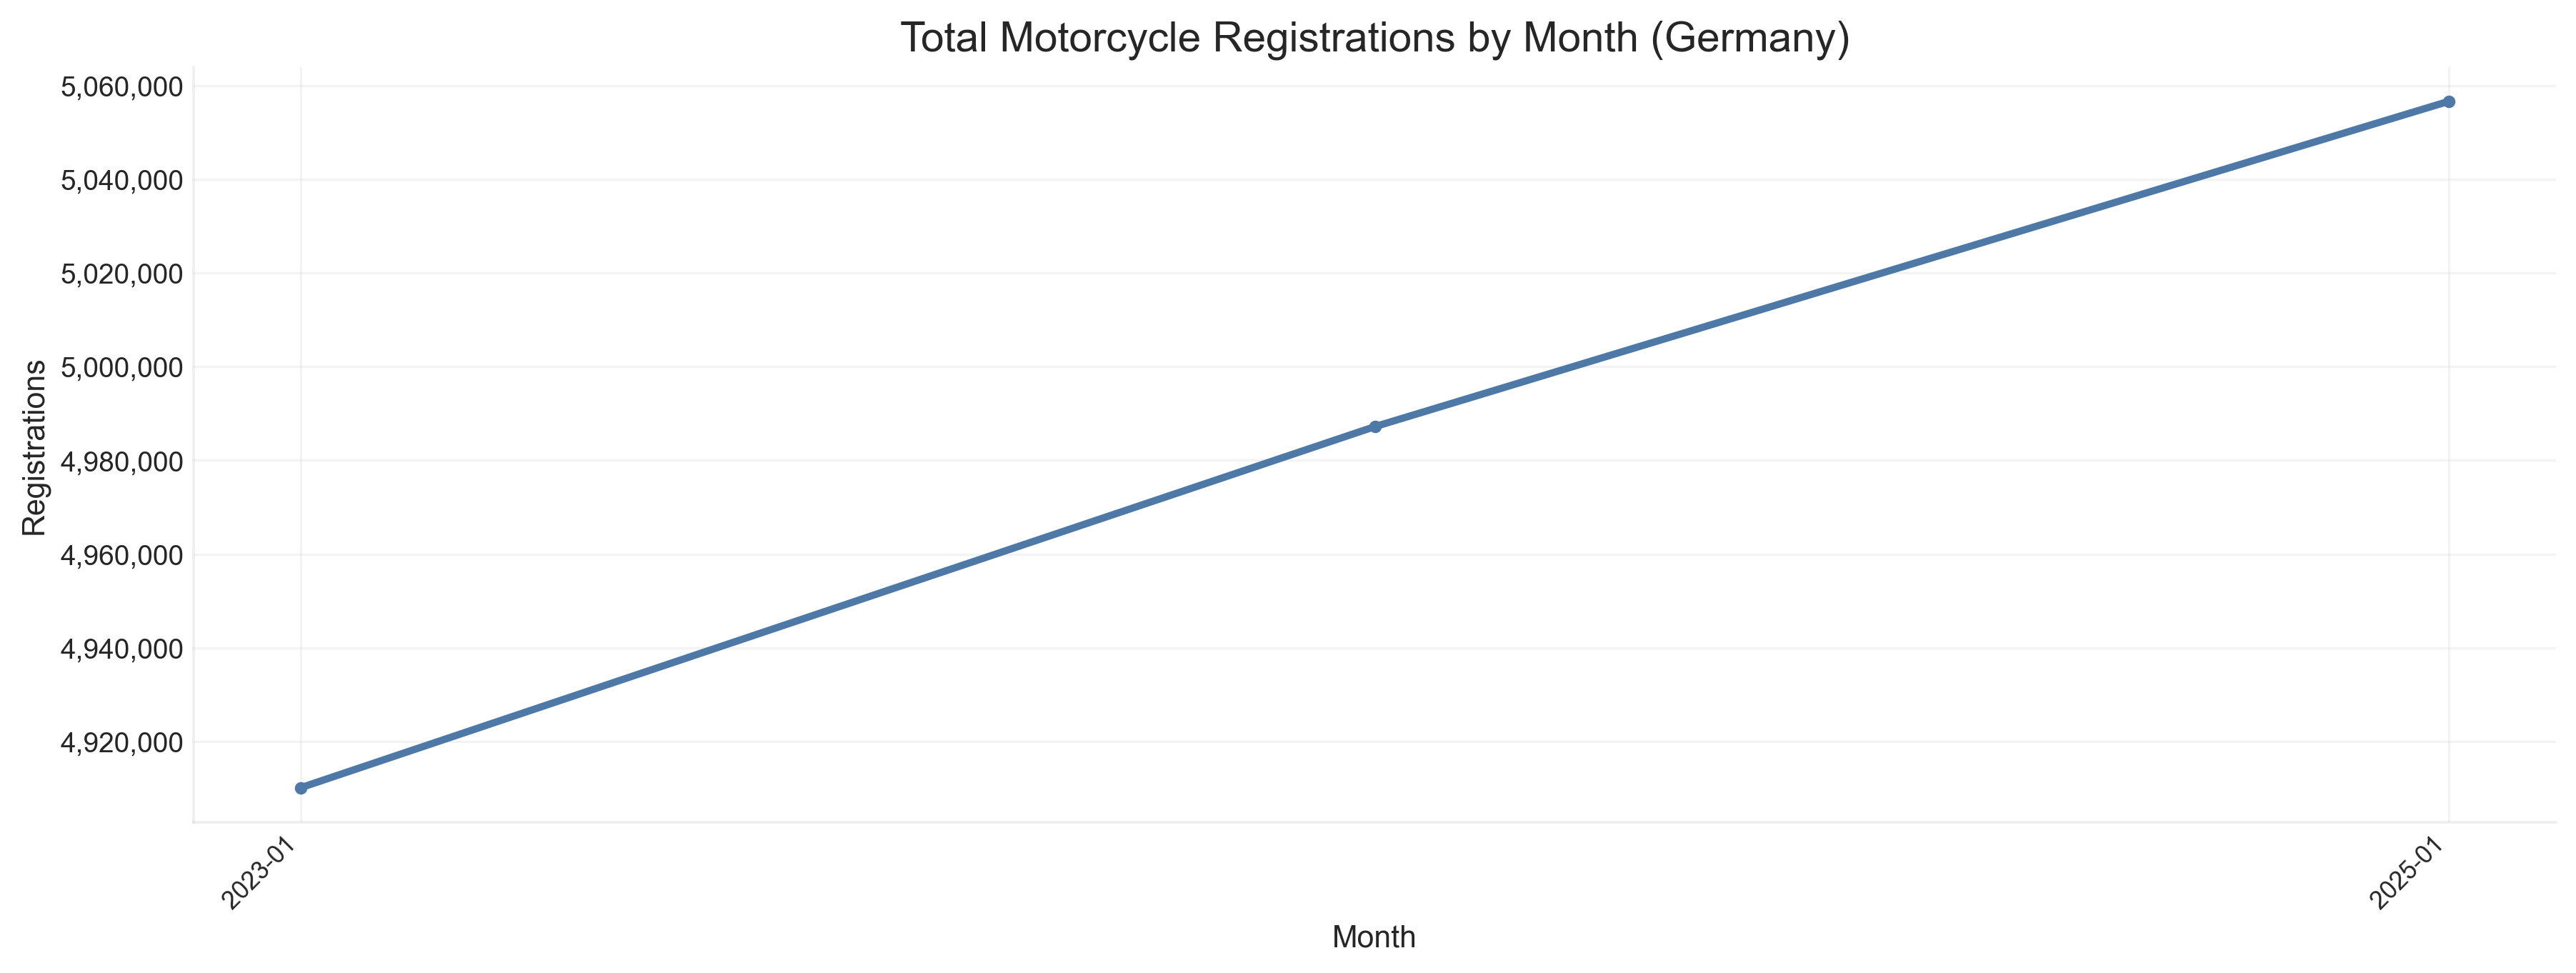

In [49]:
monthly = con.execute("""
SELECT year_month, SUM(registrations_count) AS registrations
FROM vw_registrations
GROUP BY 1
ORDER BY 1
""").fetchdf()

x = monthly["year_month"].tolist()
y = monthly["registrations"].tolist()

# show fewer x ticks (every 2 months) to avoid clutter
tick_idx = list(range(0, len(x), 2))

plt.figure(figsize=(13, 5))
ax = plt.gca()
ax.plot(x, y, linewidth=2.6, marker="o", markersize=3.5, color=HIGHLIGHT)

ax.set_title("Total Motorcycle Registrations by Month (Germany)")
ax.set_xlabel("Month")
ax.set_ylabel("Registrations")
ax.yaxis.set_major_formatter(comma_formatter)
ax.set_xticks([x[i] for i in tick_idx])
ax.set_xticklabels([x[i] for i in tick_idx], rotation=45, ha="right")

polish_axes(ax)
save_fig("01_total_registrations_by_month")
plt.show()


10.2 Registrations by year

In [50]:
import pandas as pd

# Example: build YoY change from manufacturer totals
yoy_change = con.execute("""
WITH yearly AS (
    SELECT
        year,
        SUM(registrations) AS total_registrations
    FROM mart_yoy_growth_manufacturer
    GROUP BY year
)
SELECT
    year,
    total_registrations,
    total_registrations 
      - LAG(total_registrations) OVER (ORDER BY year) AS yoy_change
FROM yearly
ORDER BY year;
""").fetchdf()

yoy_change


,year,total_registrations,yoy_change
0,2023,4910141.0,NaN
1,2024,4987191.0,77050.0
2,2025,5056626.0,69435.0


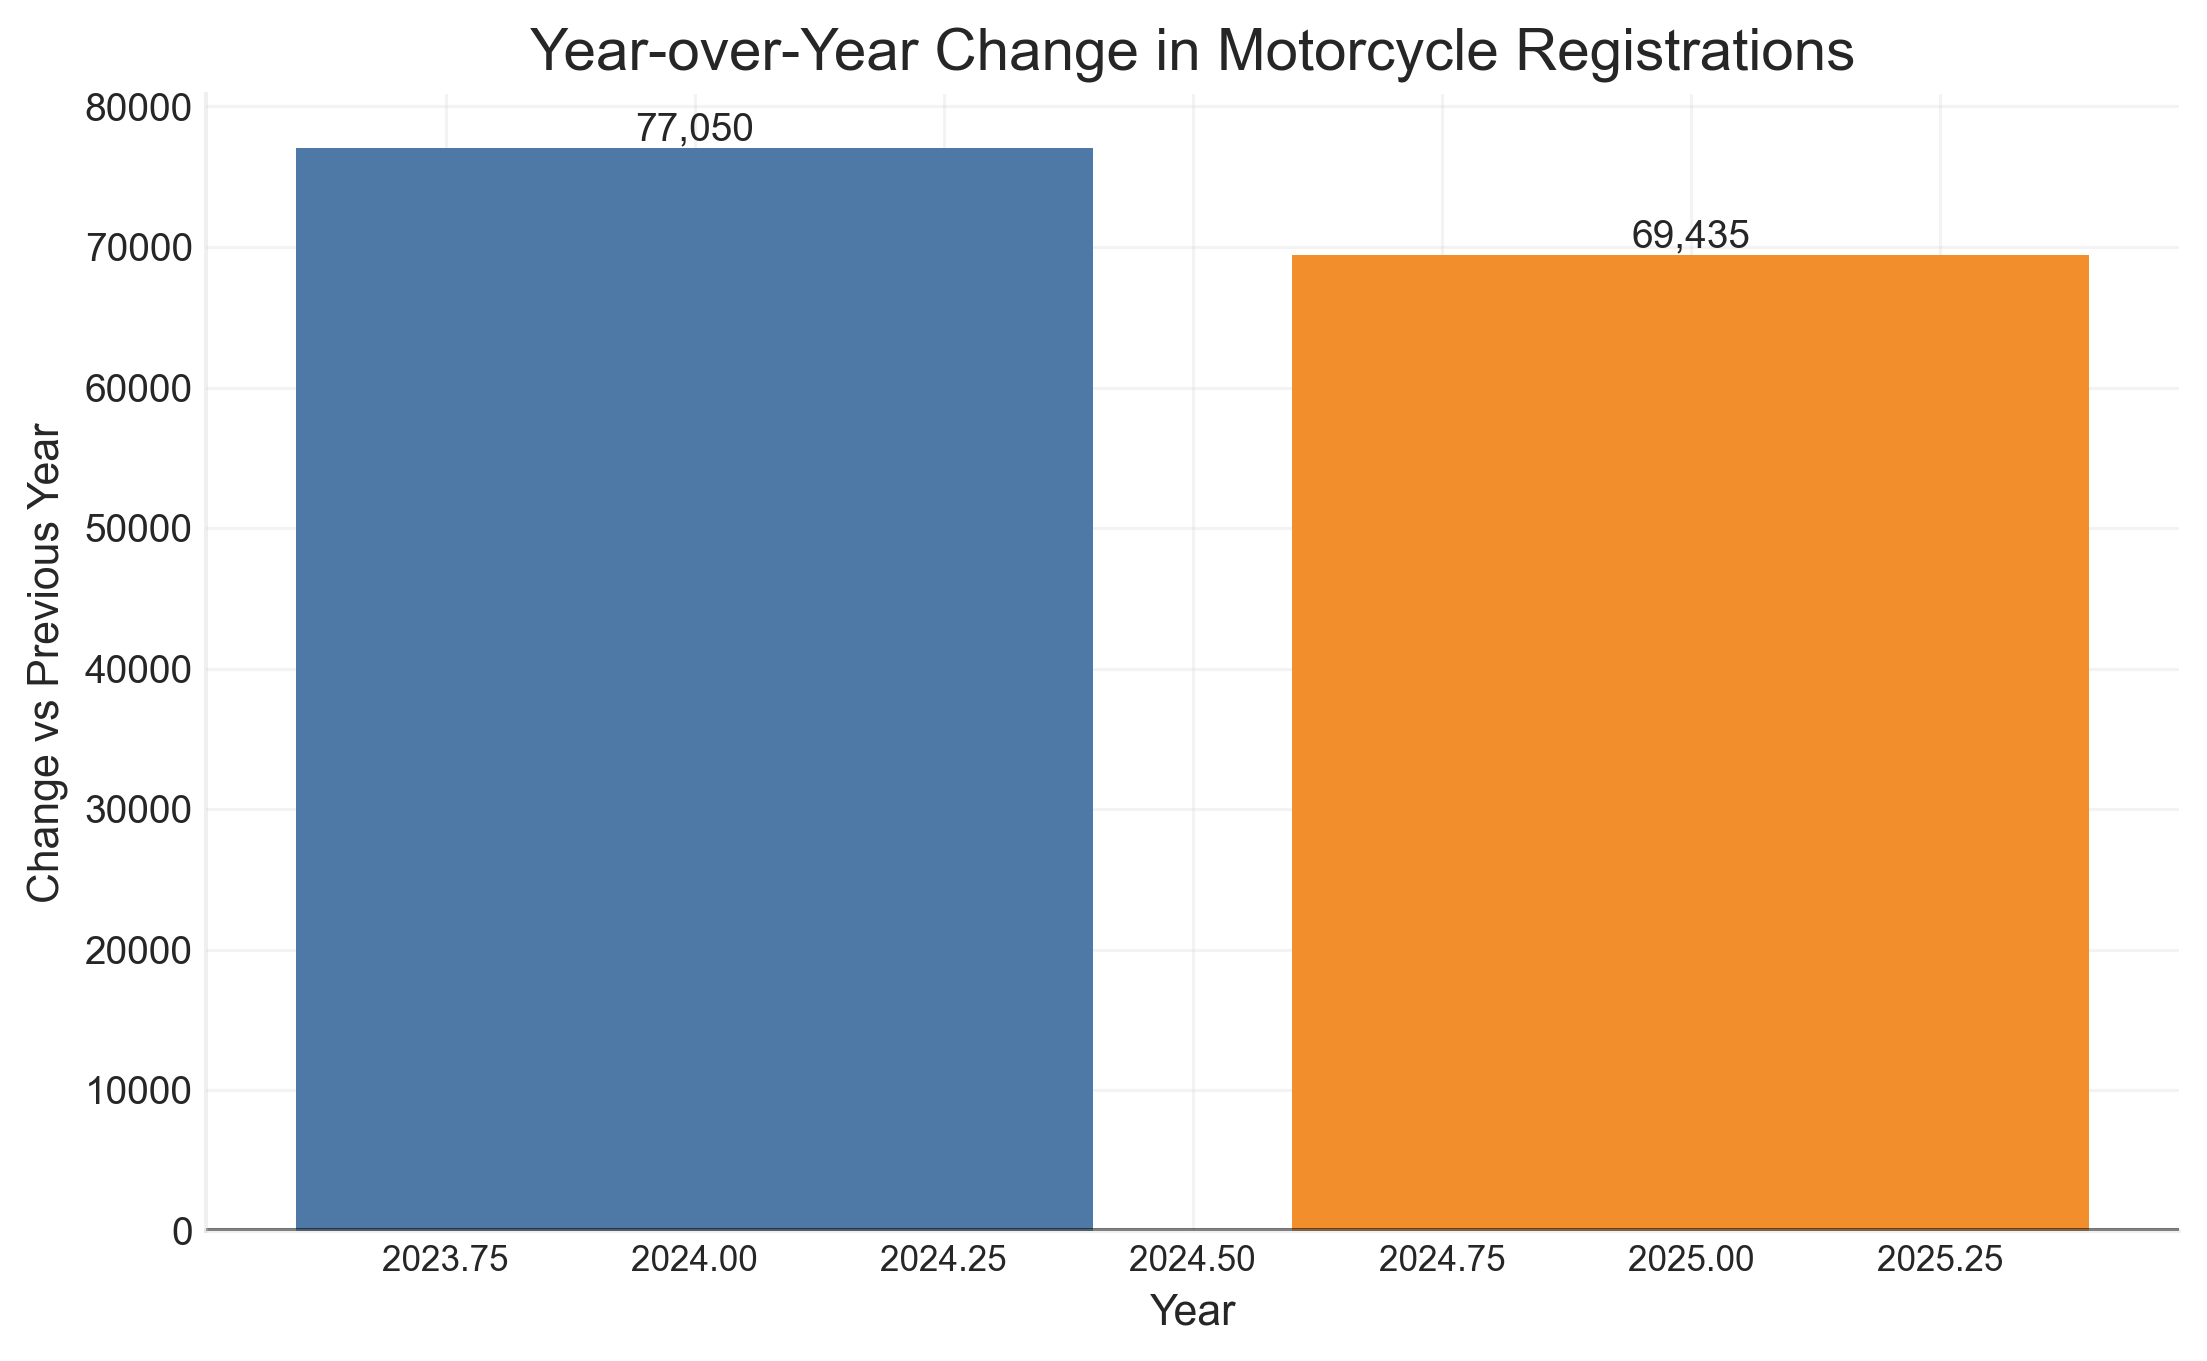

In [51]:
plt.figure(figsize=(8, 5))
ax = plt.gca()

# Explicit colors per bar (force distinction)
forced_colors = ["#BAB0AC", "#4E79A7", "#F28E2B"]  
# grey = baseline, blue = 2024, orange = 2025

ax.bar(
    yoy_change["year"],
    yoy_change["yoy_change"],
    color=forced_colors
)

ax.set_title("Year-over-Year Change in Motorcycle Registrations")
ax.set_xlabel("Year")
ax.set_ylabel("Change vs Previous Year")
ax.axhline(0, linewidth=1.5, color="black", alpha=0.6)

for i, v in enumerate(yoy_change["yoy_change"]):
    if pd.notna(v):
        ax.text(
            yoy_change["year"][i],
            v,
            f"{int(v):,}",
            ha="center",
            va="bottom",
            fontsize=10
        )

polish_axes(ax)
save_fig("02_yoy_change_distinct")
plt.show()


10.3 Top 10 manufacturers overall

In [54]:
top_m = con.execute("""
SELECT
  manufacturer,
  SUM(registrations_count) AS registrations
FROM vw_registrations
GROUP BY manufacturer
ORDER BY registrations DESC
LIMIT 10
""").fetchdf()

top_m


,manufacturer,registrations
0,BMW,1921982.0
1,YAMAHA (J),1451640.0
2,PIAGGIO (I),1390802.0
3,SUZUKI (J),1351349.0
4,HONDA MOTOR (J),1207230.0
5,KAWASAKI (J),1139497.0
6,HARLEY-DAVIDSON(USA),884592.0
7,SONSTIGE HERSTELLER,757913.0
8,KTM (A),662743.0
9,HONDA (I),450253.0


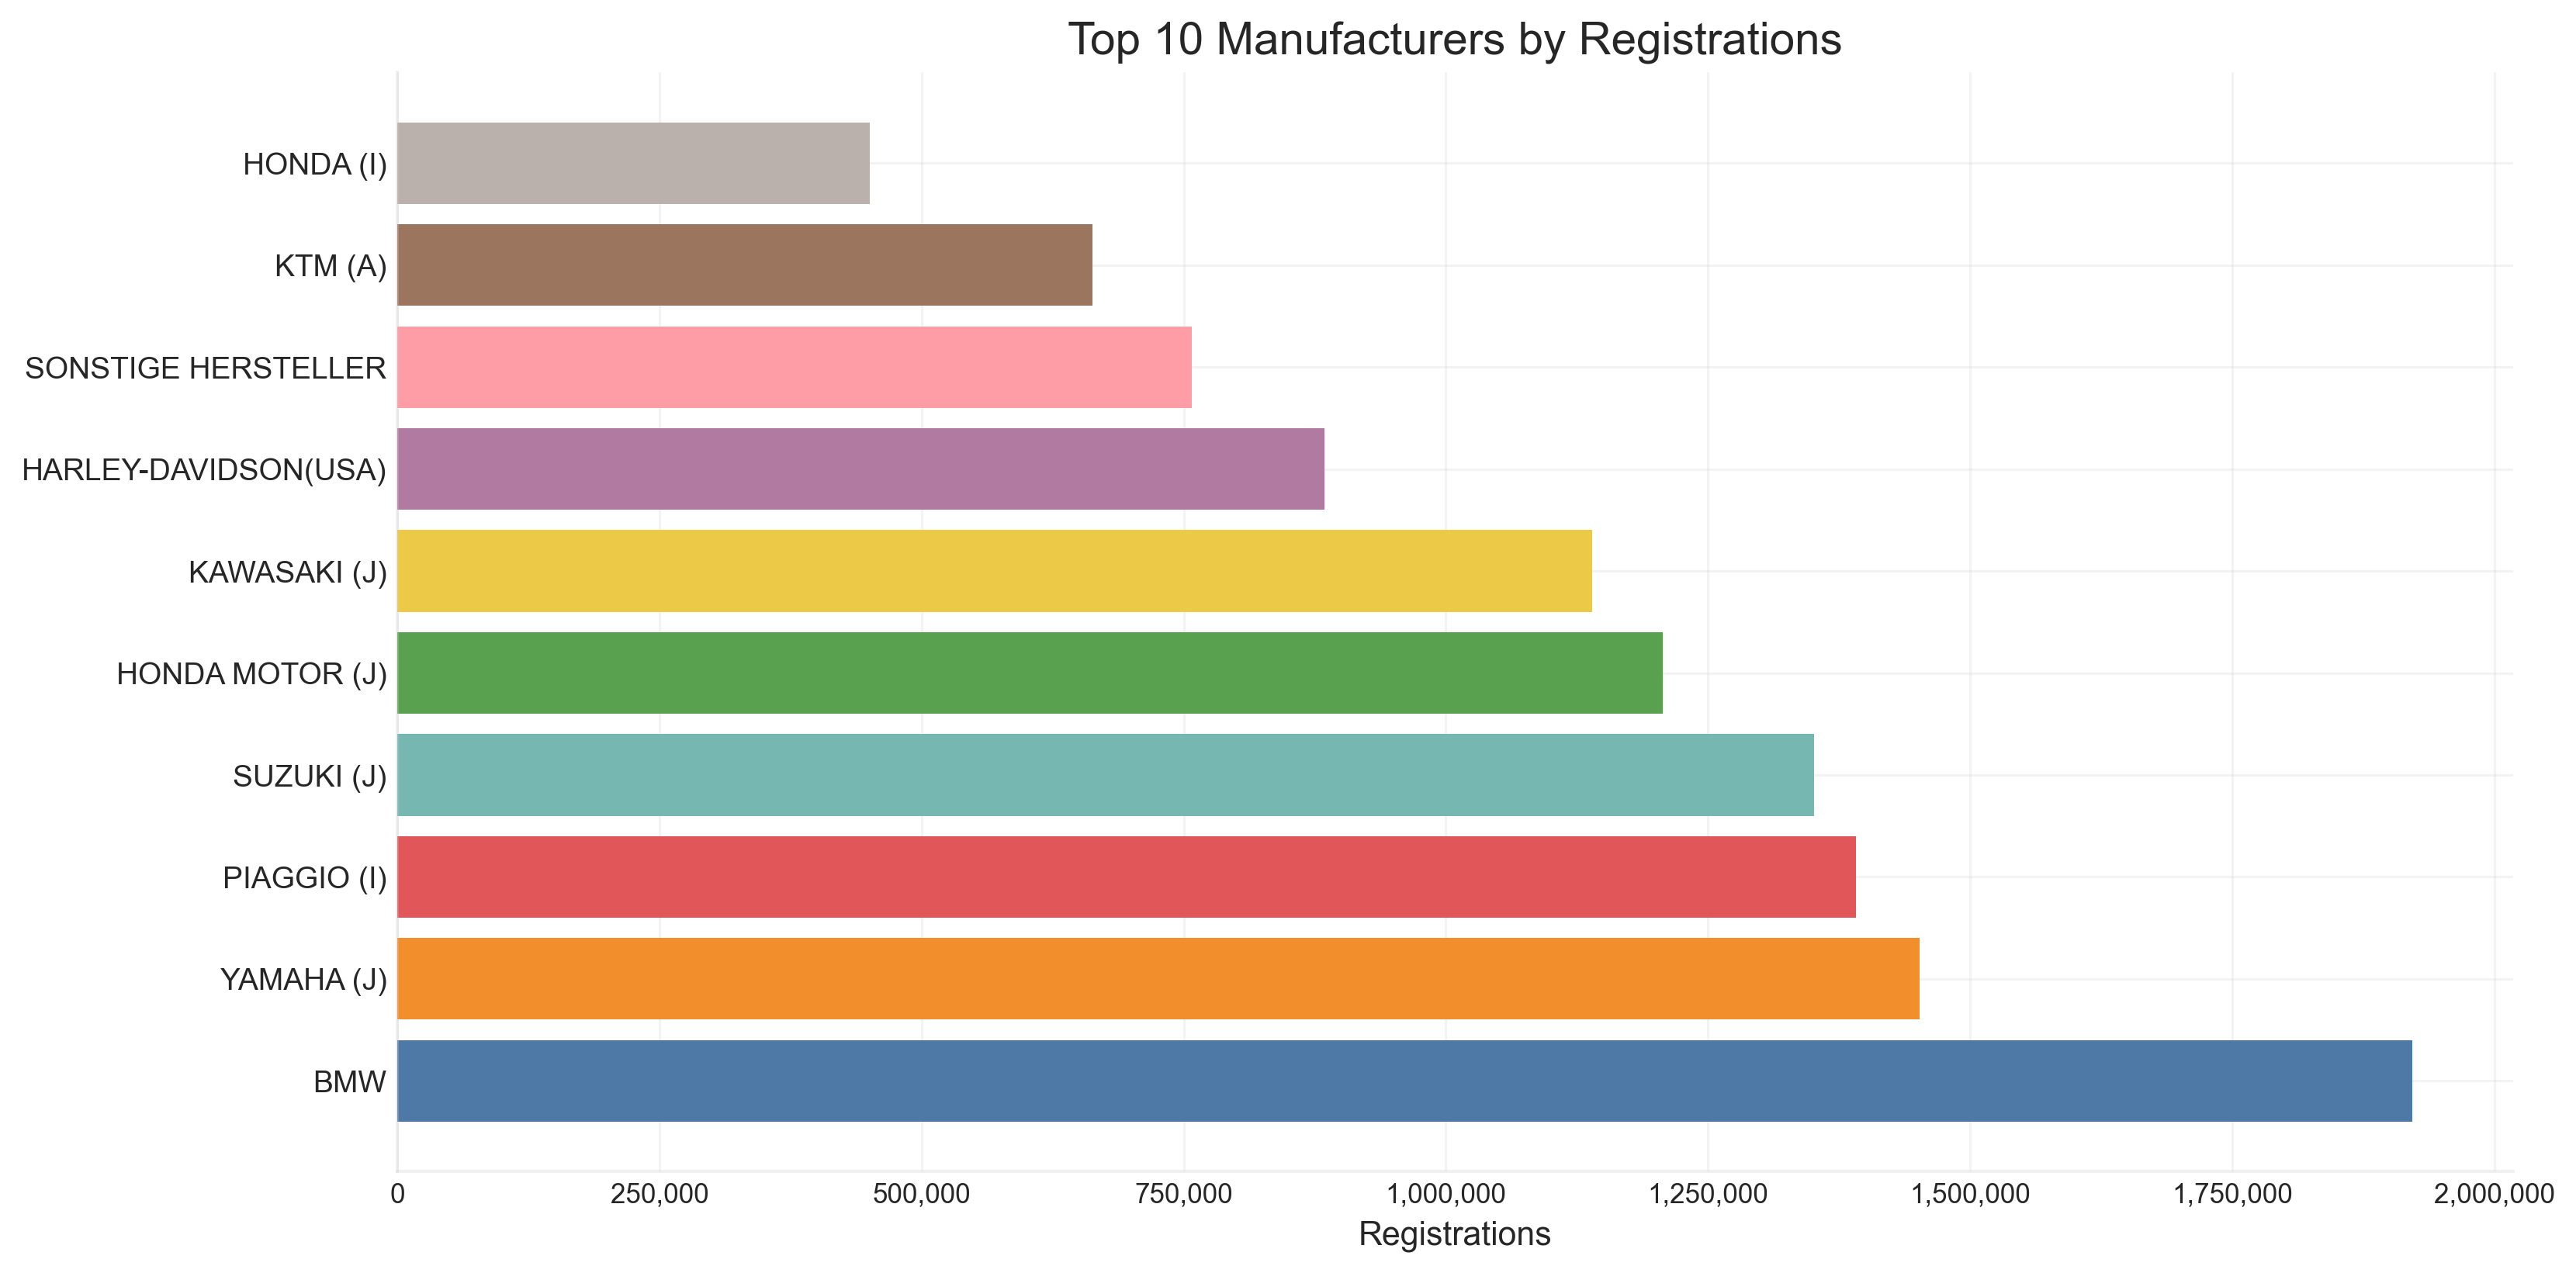

In [55]:
plt.figure(figsize=(12, 6))
ax = plt.gca()
ax.barh(top_m["manufacturer"], top_m["registrations"], color=PALETTE[:len(top_m)])

ax.set_title("Top 10 Manufacturers by Registrations")
ax.set_xlabel("Registrations")
ax.xaxis.set_major_formatter(comma_formatter)

polish_axes(ax)
save_fig("04_top10_manufacturers_multicolor")
plt.show()


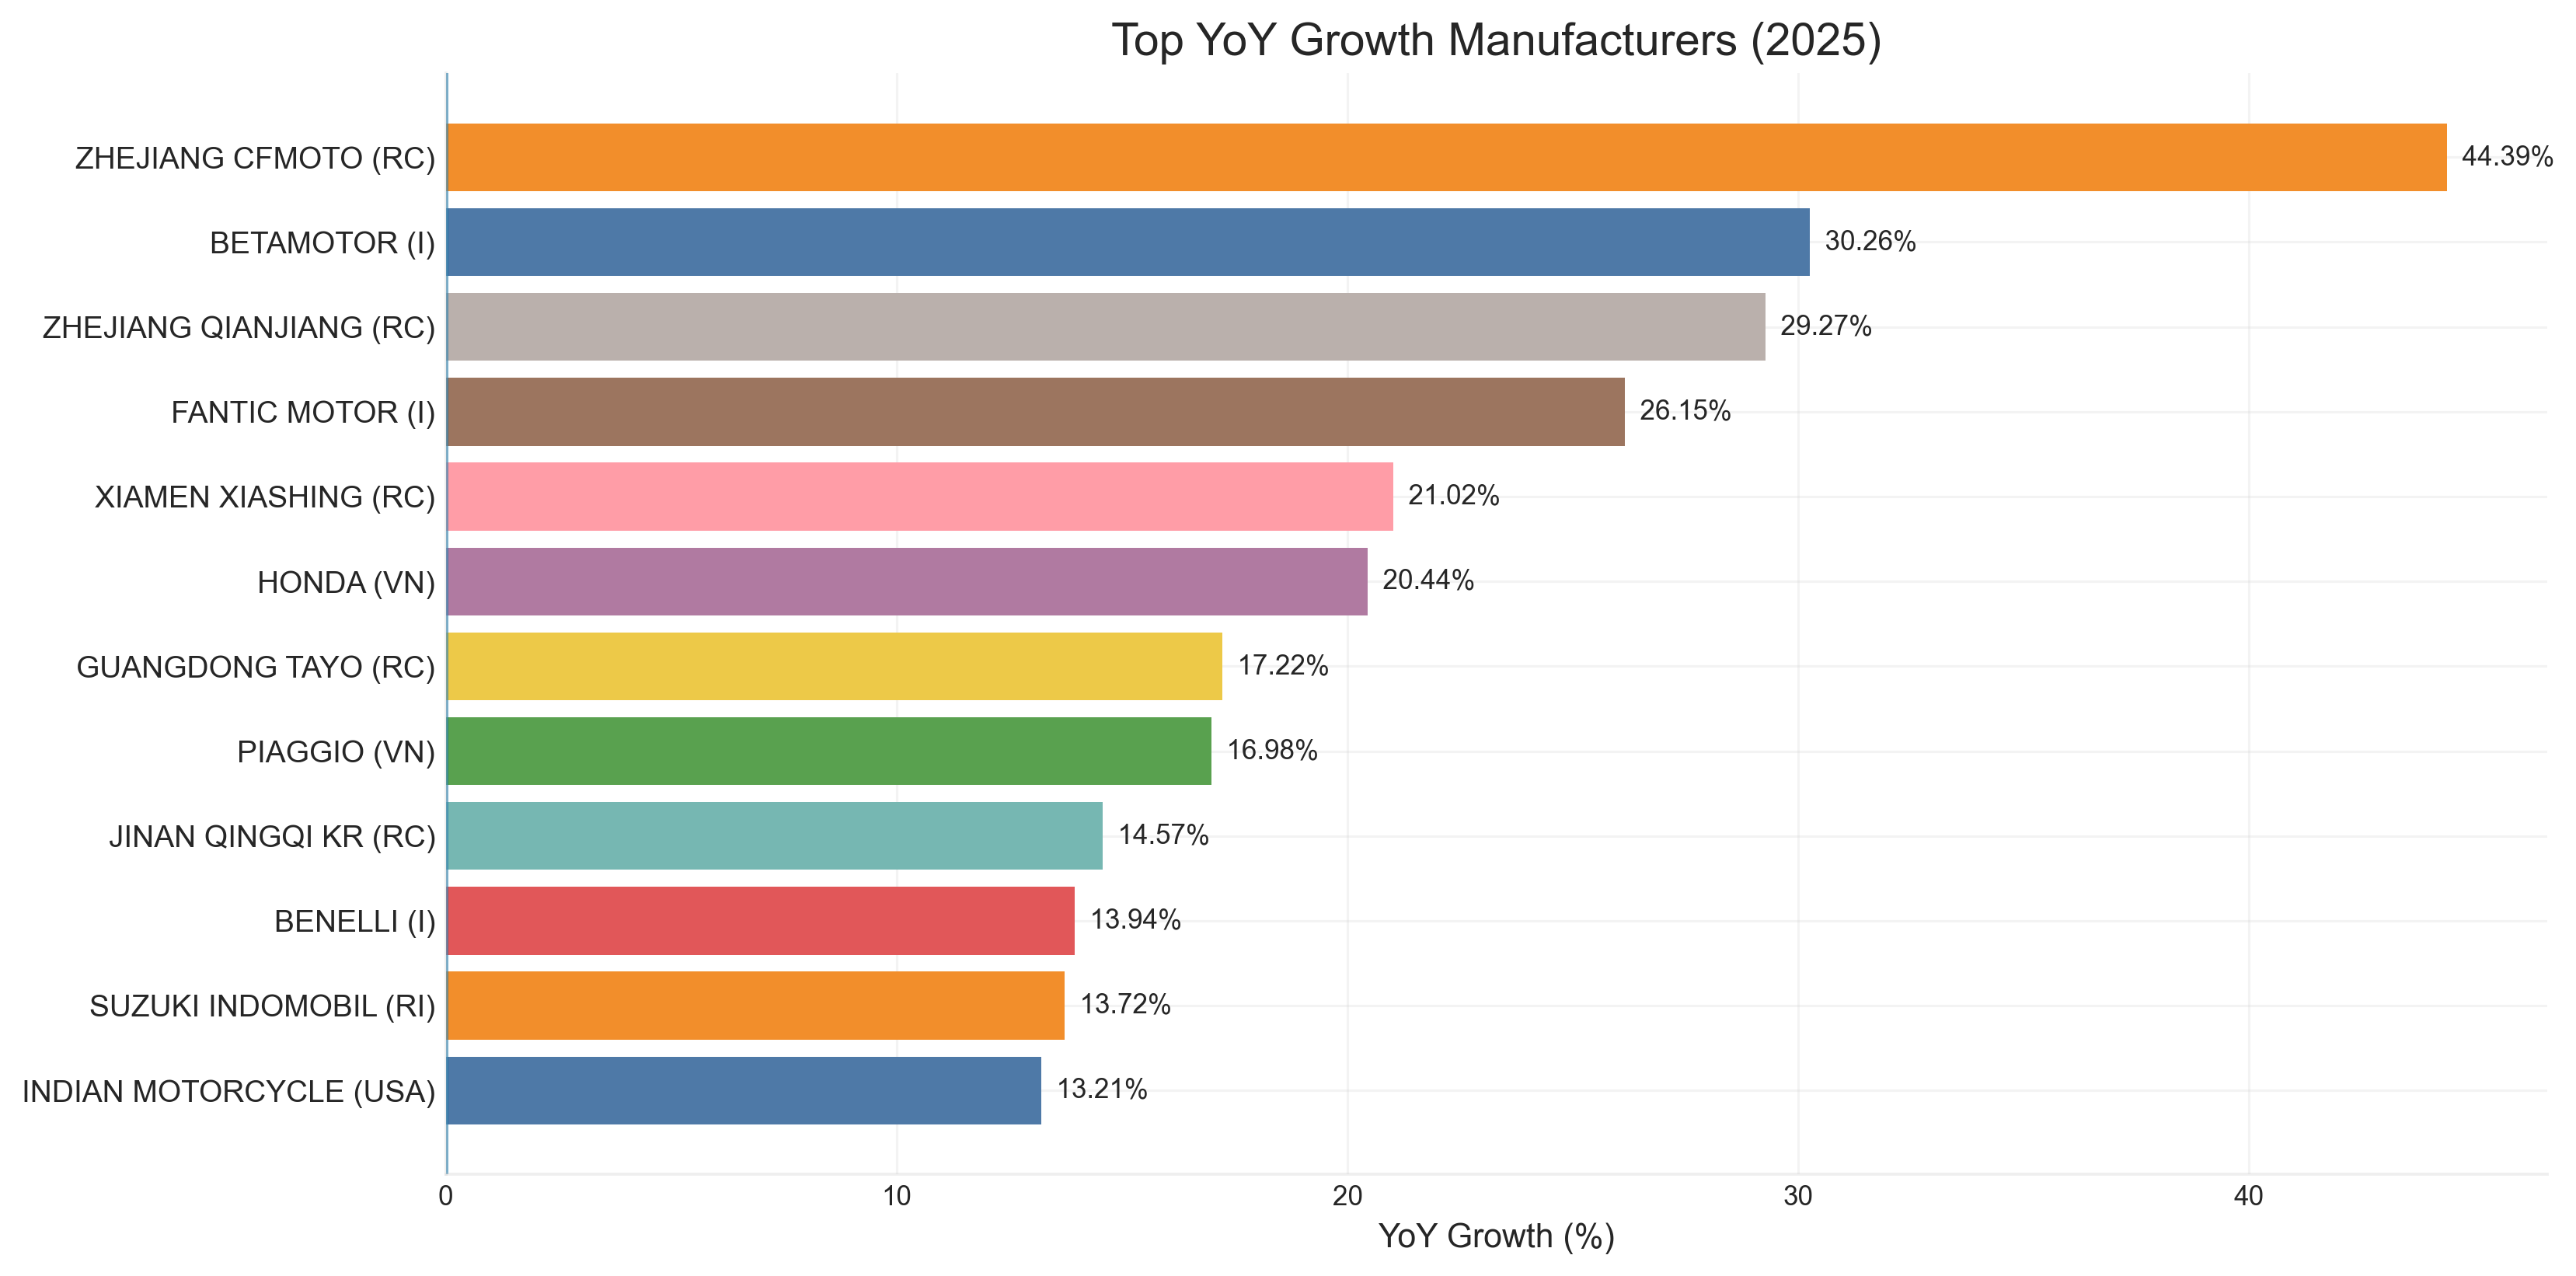

In [56]:
yoy = con.execute("""
SELECT year, manufacturer, registrations, yoy_growth_pct
FROM mart_yoy_growth_manufacturer
WHERE yoy_growth_pct IS NOT NULL
ORDER BY year DESC, yoy_growth_pct DESC
""").fetchdf()

latest_year = int(yoy["year"].max())
yoy_latest = yoy[yoy["year"] == latest_year].head(12).copy()
yoy_latest = yoy_latest.sort_values("yoy_growth_pct")  # barh looks better sorted

plt.figure(figsize=(12, 6))
ax = plt.gca()
ax.barh(yoy_latest["manufacturer"], yoy_latest["yoy_growth_pct"], color=PALETTE[:len(yoy_latest)])

ax.set_title(f"Top YoY Growth Manufacturers ({latest_year})")
ax.set_xlabel("YoY Growth (%)")
ax.axvline(0, linewidth=1.5, alpha=0.6)

for i, v in enumerate(yoy_latest["yoy_growth_pct"]):
    ax.text(v, i, f"  {v:.2f}%", va="center", fontsize=9)

polish_axes(ax)
save_fig("06_top_yoy_growth_latest_year")
plt.show()


Top manufacturers in a state

/var/folders/82/qk_7zy_s1rdcmb28mvs3jpch0000gn/T/ipykernel_54383/330864267.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(state_top["manufacturer"], rotation=45, ha="right")


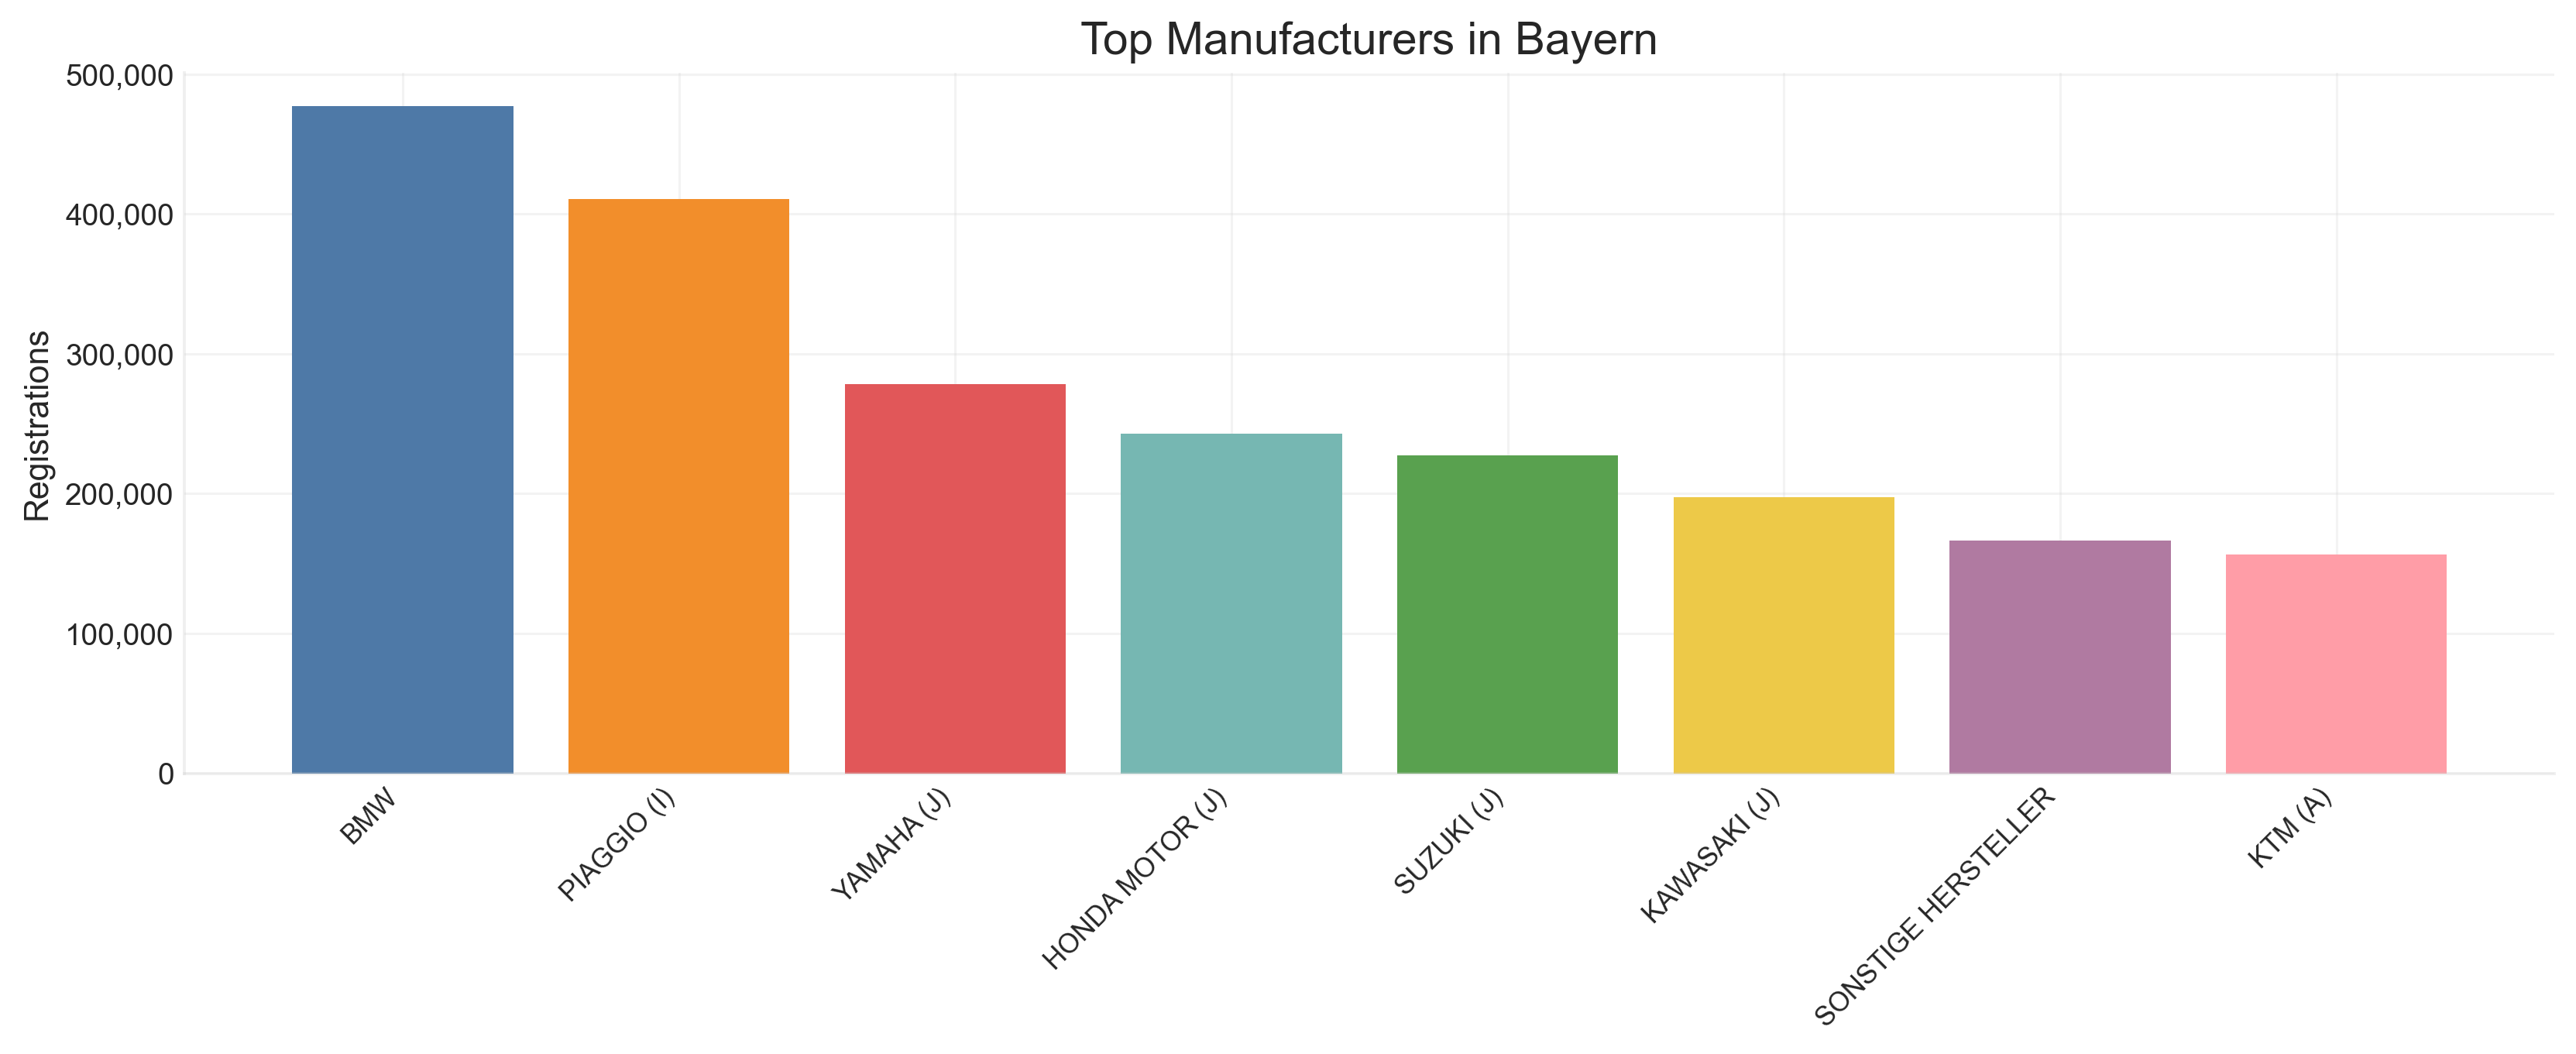

In [57]:
state = "Bayern"

state_top = con.execute(f"""
SELECT manufacturer, registrations
FROM mart_state_manufacturer_rank
WHERE state = '{state}'
  AND manufacturer_rank_in_state <= 8
ORDER BY registrations DESC
""").fetchdf()

plt.figure(figsize=(12, 5))
ax = plt.gca()
ax.bar(state_top["manufacturer"], state_top["registrations"], color=PALETTE[:len(state_top)])

ax.set_title(f"Top Manufacturers in {state}")
ax.set_ylabel("Registrations")
ax.yaxis.set_major_formatter(comma_formatter)
ax.set_xticklabels(state_top["manufacturer"], rotation=45, ha="right")

polish_axes(ax)
save_fig(f"07_top_manufacturers_{state.lower().replace(' ', '_')}")
plt.show()


In [59]:
con.close()

In [58]:
con.execute("""
SELECT MIN(month) AS min_month, MAX(month) AS max_month, COUNT(DISTINCT month) AS distinct_months
FROM vw_registrations
""").fetchdf()


,min_month,max_month,distinct_months
0,1,1,1
